In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

from epistatic_net.wht_sampling import SPRIGHTSample
from epistatic_net.spright_utils import SPRIGHT, make_system_simple

from utils import ModelTrainer
from datasets import FourierDataset

# Set seeds
random_seed = 22
fix_seed = 3
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [62]:
test_n = 12
test_k = 12
test_d = 2
test_b = 4
dataset_size_coef = 8
test_n_samples =  2**test_n

dataset = FourierDataset(n=test_n, k=test_k, d=test_d, n_samples=test_n_samples, random_seed=fix_seed,
                        freq_sampling_method="fixed_deg")
print(sorted(dataset.get_int_freqs()))
print(sorted(dataset.amp_f))
print(dataset.X.shape)

[5, 24, 48, 258, 320, 544, 1028, 1032, 1088, 2056, 2304, 3072]
[tensor(-0.9348), tensor(-0.6981), tensor(-0.4208), tensor(-0.1932), tensor(-0.0315), tensor(0.2250), tensor(0.4072), tensor(0.5341), tensor(0.6934), tensor(0.8203), tensor(0.8213), tensor(0.8631)]
torch.Size([4096, 12])


In [63]:
train_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n)))
val_ds = torch.utils.data.Subset(dataset, list(range(dataset_size_coef * test_k * test_n, test_n_samples)))
print(len(train_ds), len(val_ds))

1152 2944


In [64]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

#0 - Train Loss: 0.037, R2: -0.058	Validation Loss: 0.051, R2: -0.653
#1 - Train Loss: 0.014, R2: 0.597	Validation Loss: 0.043, R2: -0.413
#2 - Train Loss: 0.006, R2: 0.814	Validation Loss: 0.062, R2: -1.024
#3 - Train Loss: 0.004, R2: 0.894	Validation Loss: 0.045, R2: -0.473
#4 - Train Loss: 0.003, R2: 0.923	Validation Loss: 0.049, R2: -0.593
#5 - Train Loss: 0.002, R2: 0.954	Validation Loss: 0.051, R2: -0.659
#6 - Train Loss: 0.001, R2: 0.966	Validation Loss: 0.053, R2: -0.725
#7 - Train Loss: 0.001, R2: 0.973	Validation Loss: 0.052, R2: -0.700
#8 - Train Loss: 0.001, R2: 0.978	Validation Loss: 0.050, R2: -0.638
#9 - Train Loss: 0.001, R2: 0.981	Validation Loss: 0.048, R2: -0.578
#10 - Train Loss: 0.000, R2: 0.986	Validation Loss: 0.052, R2: -0.717
#11 - Train Loss: 0.000, R2: 0.989	Validation Loss: 0.051, R2: -0.666
#12 - Train Loss: 0.000, R2: 0.989	Validation Loss: 0.047, R2: -0.524
#13 - Train Loss: 0.000, R2: 0.992	Validation Loss: 0.046, R2: -0.512
#14 - Train Loss: 0.000, R2: 

#119 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.042, R2: -0.383
#120 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.042, R2: -0.384
#121 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.041, R2: -0.328
#122 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.042, R2: -0.390
#123 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.044, R2: -0.423
#124 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.045, R2: -0.466
#125 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.044, R2: -0.446
#126 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.042, R2: -0.377
#127 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.042, R2: -0.363
#128 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.046, R2: -0.510
#129 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.050, R2: -0.638
#130 - Train Loss: 0.000, R2: 0.989	Validation Loss: 0.036, R2: -0.190
#131 - Train Loss: 0.000, R2: 0.992	Validation Loss: 0.041, R2: -0.331
#132 - Train Loss: 0.000, R2: 0.993	Validation Loss: 0.049, R2: -0.605
#133 -

#37 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.026, R2: 0.162
#38 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.026, R2: 0.144
#39 - Train Loss: 0.000, R2: 0.991	Validation Loss: 0.025, R2: 0.173
#40 - Train Loss: 0.000, R2: 0.992	Validation Loss: 0.026, R2: 0.154
#41 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.156
#42 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.142
#43 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.151
#44 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.026, R2: 0.147
#45 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.027, R2: 0.127
#46 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.027, R2: 0.131
#47 - Train Loss: 0.000, R2: 0.995	Validation Loss: 0.027, R2: 0.101
#48 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.027, R2: 0.121
#49 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.027, R2: 0.108
#50 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.139
#51 - Train Loss: 0.000, R2: 0.998

#155 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.027, R2: 0.115
#156 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.027, R2: 0.133
#157 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.027, R2: 0.123
#158 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.027, R2: 0.107
#159 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.029, R2: 0.054
#160 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.028, R2: 0.092
#161 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.028, R2: 0.087
#162 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.028, R2: 0.071
#163 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.028, R2: 0.099
#164 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.028, R2: 0.093
#165 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.137
#166 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.027, R2: 0.121
#167 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.027, R2: 0.101
#168 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.026, R2: 0.149
#169 - Train Loss: 0

#73 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.017, R2: 0.428
#74 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.018, R2: 0.397
#75 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.018, R2: 0.414
#76 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.017, R2: 0.428
#77 - Train Loss: 0.000, R2: 0.995	Validation Loss: 0.019, R2: 0.388
#78 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.025, R2: 0.194
#79 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.018, R2: 0.421
#80 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.027, R2: 0.125
#81 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.034, R2: -0.127
#82 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.037, R2: -0.211
#83 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.023, R2: 0.245
#84 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.064, R2: -1.102
#85 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.052, R2: -0.699
#86 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.076, R2: -1.479
#87 - Train Loss: 0.000, R2: 

#190 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.020, R2: 0.345
#191 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.043, R2: -0.410
#192 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.035, R2: -0.145
#193 - Train Loss: 0.000, R2: 0.997	Validation Loss: 0.026, R2: 0.147
#194 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.040, R2: -0.316
#195 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.030, R2: 0.009
#196 - Train Loss: 0.000, R2: 0.999	Validation Loss: 0.015, R2: 0.497
#197 - Train Loss: 0.000, R2: 0.998	Validation Loss: 0.038, R2: -0.233
#198 - Train Loss: 0.000, R2: 0.996	Validation Loss: 0.075, R2: -1.456
#199 - Train Loss: 0.000, R2: 0.994	Validation Loss: 0.058, R2: -0.893
#0 - Train Loss: 0.039, R2: -0.118	Validation Loss: 0.038, R2: -0.254
#1 - Train Loss: 0.019, R2: 0.455	Validation Loss: 0.043, R2: -0.411
#2 - Train Loss: 0.016, R2: 0.537	Validation Loss: 0.042, R2: -0.365
#3 - Train Loss: 0.014, R2: 0.593	Validation Loss: 0.041, R2: -0.344
#4 - Train Loss: 

#110 - Train Loss: 0.002, R2: 0.942	Validation Loss: 0.023, R2: 0.254
#111 - Train Loss: 0.002, R2: 0.939	Validation Loss: 0.022, R2: 0.281
#112 - Train Loss: 0.002, R2: 0.937	Validation Loss: 0.022, R2: 0.264
#113 - Train Loss: 0.002, R2: 0.937	Validation Loss: 0.022, R2: 0.282
#114 - Train Loss: 0.002, R2: 0.941	Validation Loss: 0.022, R2: 0.282
#115 - Train Loss: 0.002, R2: 0.939	Validation Loss: 0.023, R2: 0.257
#116 - Train Loss: 0.002, R2: 0.941	Validation Loss: 0.022, R2: 0.295
#117 - Train Loss: 0.002, R2: 0.938	Validation Loss: 0.022, R2: 0.290
#118 - Train Loss: 0.002, R2: 0.935	Validation Loss: 0.021, R2: 0.308
#119 - Train Loss: 0.002, R2: 0.932	Validation Loss: 0.021, R2: 0.306
#120 - Train Loss: 0.002, R2: 0.939	Validation Loss: 0.021, R2: 0.297
#121 - Train Loss: 0.002, R2: 0.942	Validation Loss: 0.021, R2: 0.305
#122 - Train Loss: 0.002, R2: 0.937	Validation Loss: 0.023, R2: 0.245
#123 - Train Loss: 0.002, R2: 0.935	Validation Loss: 0.022, R2: 0.270
#124 - Train Loss: 0

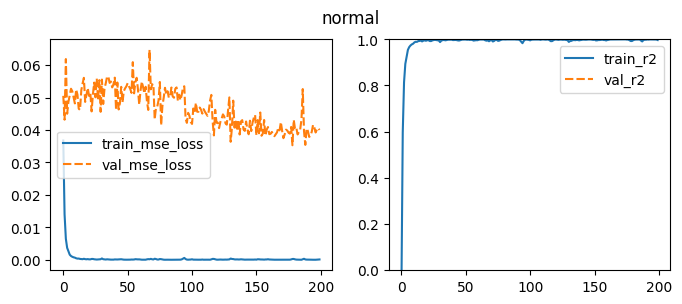

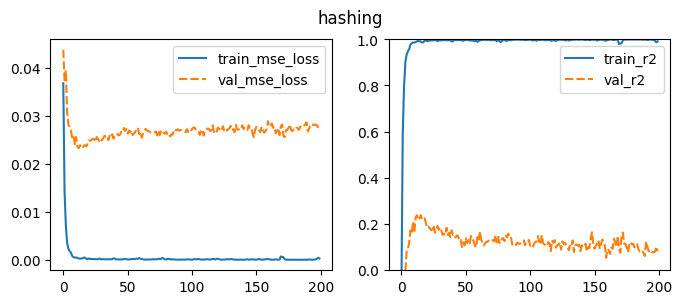

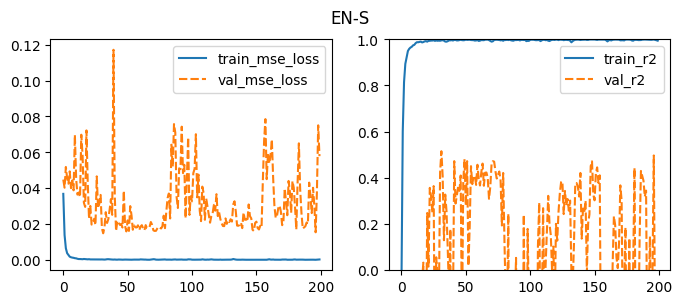

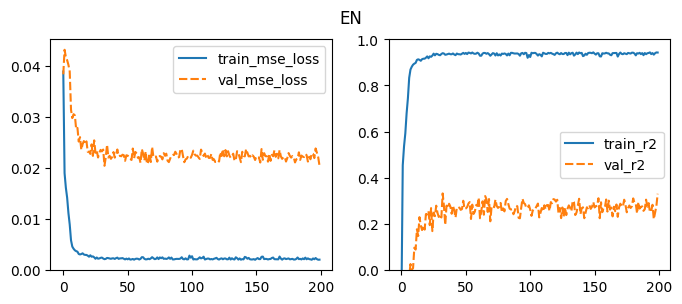

In [65]:
config = {
    "training_method": "normal",
    "add_hadamard_loss": True, 
    "n": test_n,
    "k": test_k,
    "b": test_b,
    "d": test_d,
    "SPRIGHT_m": test_b,
    "SPRIGHT_d": 5,
    "rho": 0.01,
    "lr": 1e-2, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.001,
    "num_epochs": 200,
    "batch_size": 32,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "fix_deg": True,
    "train_size": len(train_ds),
}

# Train model
in_dim = dataset.X.shape[1]
args = {"int_freqs": dataset.get_int_freqs(), "amps":dataset.amp_f.cpu().numpy()}

torch.manual_seed(random_seed)
model = FCN(in_dim, 2)
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums_norm = trainer.train_model()
best_norm = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])

torch.manual_seed(random_seed)
model = FCN(in_dim, 2)
config["training_method"] = "hashing"
config["hadamard_lambda"] = 0.001
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums_hash = trainer.train_model()
best_hash = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])

torch.manual_seed(random_seed)
model = FCN(in_dim, 2)
config["training_method"] = "EN-S"
config["hadamard_lambda"] = 1
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums_EN_S = trainer.train_model()
best_EN_S = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])

torch.manual_seed(random_seed)
model = FCN(in_dim, 2)
config["training_method"] = "EN"
config["hadamard_lambda"] = 1
trainer = ModelTrainer(model, train_ds, val_ds, config=config, report_epoch_fourier=True, plot_results=True, checkpoint_cache=True, **args)
spectrums_EN = trainer.train_model()
best_EN = np.argmin([l["val_mse_loss"] for l in trainer.logs[1:]])
print(best_norm, best_hash, best_EN_S, best_EN)

/scratch/246441190.tmpdir/ipykernel_36013/720009602.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


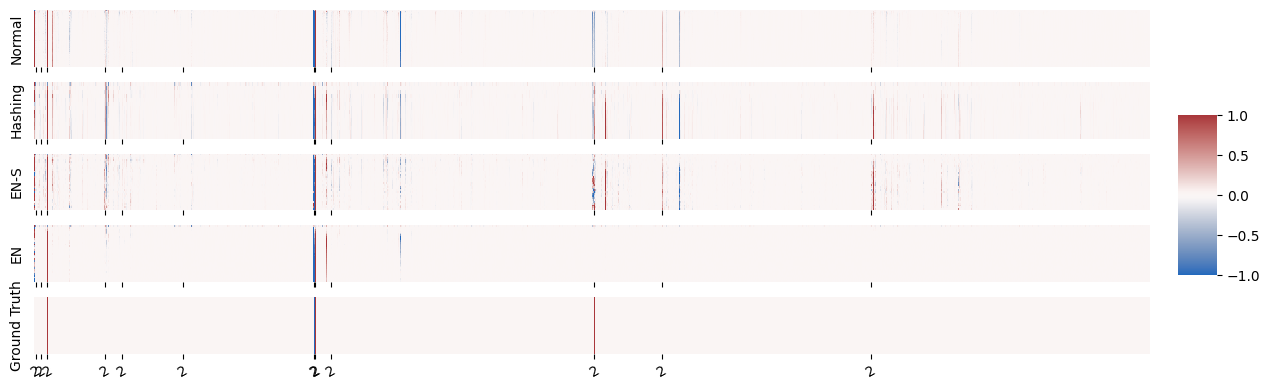

In [66]:
def normalize_spectrum(calculated_spectrum, target_spectrum):
    target_var = np.std(target_spectrum)
    return np.where(target_spectrum != 0, calculated_spectrum/target_spectrum, calculated_spectrum/target_var)

fig, axes = plt.subplots(5, 1, figsize=(13, 4), sharex=True)

ground_spectrum = np.vstack(dataset.get_fourier_spectrum()*((2**(test_n/2))/test_k)).reshape(1, -1)

data_norm = np.vstack(spectrums_norm[:best_norm])
data_hash = np.vstack(spectrums_hash[:best_hash])
data_EN_S = np.vstack(spectrums_EN_S[:best_EN_S])
data_EN = np.vstack(spectrums_EN[:best_EN])

data_range = 1
# np.max([np.abs(data_norm), np.abs(data_hash), np.abs(data_EN_S)])
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(data_norm, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[0], cbar=True, cbar_ax=cbar_ax)
sns.heatmap(data_hash, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[1], cbar=False)
sns.heatmap(data_EN_S, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[2], cbar=False)
sns.heatmap(data_EN, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[3], cbar=False)
sns.heatmap(ground_spectrum, cmap="vlag", vmin=-data_range, vmax=data_range, ax=axes[4], cbar=False)

freq_degrees = torch.sum(dataset.freq_f, axis=1).int().tolist()
for ax in axes:
    ax.set_xticks(dataset.get_int_freqs(), freq_degrees, rotation=30)
    ax.set_yticks([])
axes[0].set_ylabel("Normal")
axes[1].set_ylabel("Hashing")
axes[2].set_ylabel("EN-S")
axes[3].set_ylabel("EN")
axes[4].set_ylabel("Ground Truth")
fig.tight_layout(rect=[0, 0, .9, 1])



[2304  258   24 2056 3072  544   48 1028  320 1032    5 1088]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[5, 24, 48, 258, 320, 544, 1028, 1032, 1088, 2056, 2304, 3072]


<AxesSubplot: title={'center': 'EN'}>

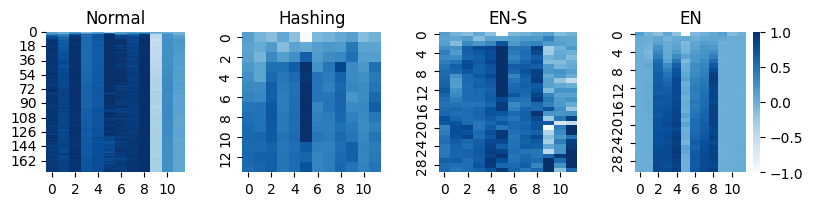

In [67]:
int_freqs = dataset.get_int_freqs()
print(int_freqs)
print(freq_degrees)
int_freqs = [x for _, x in sorted(zip(freq_degrees, int_freqs))]
print(int_freqs)


fig, axes = plt.subplots(1, 4, figsize=(8, 2))
fig.tight_layout()
axes[0].set_title("Normal")
axes[1].set_title("Hashing")
axes[2].set_title("EN-S")
axes[3].set_title("EN")

data_range = 1
sns.heatmap(data_norm[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[0], cbar=False)
sns.heatmap(data_hash[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[1], cbar=False)
sns.heatmap(data_EN_S[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[2], cbar=False)
sns.heatmap(data_EN[:, int_freqs] / ground_spectrum[0, int_freqs], cmap="Blues", vmin=-data_range, vmax=data_range, ax=axes[3])


<AxesSubplot: >

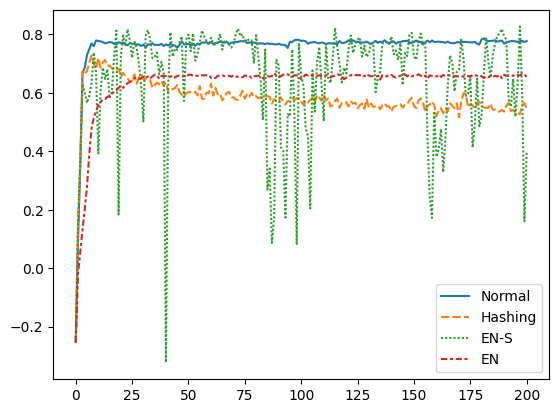

In [68]:
norm_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_norm[epoch][int_freqs]) for epoch in range(len(spectrums_norm))]
hash_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_hash[epoch][int_freqs]) for epoch in range(len(spectrums_hash))]
EN_S_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_EN_S[epoch][int_freqs]) for epoch in range(len(spectrums_EN_S))]
EN_diff = [r2_score(ground_spectrum[0, int_freqs], spectrums_EN[epoch][int_freqs]) for epoch in range(len(spectrums_EN))]

data = {"Normal": norm_diff, "Hashing": hash_diff, "EN-S": EN_S_diff, "EN": EN_diff}
sns.lineplot(data)

<AxesSubplot: >

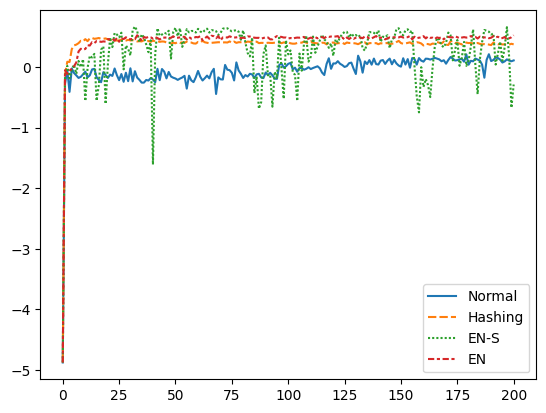

In [69]:
def covered_energy(ground_amps, learned_amps):
    return 1 - np.sum((learned_amps-ground_amps)**2) / np.sum(ground_amps**2)

norm_diff = [covered_energy(ground_spectrum[0], spectrums_norm[epoch]) for epoch in range(len(spectrums_norm))]
hash_diff = [covered_energy(ground_spectrum[0], spectrums_hash[epoch]) for epoch in range(len(spectrums_hash))]
EN_S_diff = [covered_energy(ground_spectrum[0], spectrums_EN_S[epoch]) for epoch in range(len(spectrums_EN_S))]
EN_diff = [covered_energy(ground_spectrum[0], spectrums_EN[epoch]) for epoch in range(len(spectrums_EN))]

data = {"Normal": norm_diff, "Hashing": hash_diff, "EN-S": EN_S_diff, "EN": EN_diff}
sns.lineplot(data)